Garrett Kelly

DA 320

Midterm

The question I will be asking is as follows: "How are gross sales of Super Hero movies effected by the runtime, rating, and budget". In my attempts to answer this question I will be applying regression analysis to this question.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import pymongo
import pprint
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy import stats

In [2]:
#Retrieve connection string from file
with open("credentials.json") as f:
    data = json.load(f)
    conn_str = data['mongodb']

#Connect to database and verify that it is working
client = pymongo.MongoClient(conn_str)
db = client.NoSQL_Assignment

#Verify the data was loaded successfully with a head call
cursor = db['imdb'].find()
df = pd.DataFrame(list(cursor))
df.head()

,_id,ID,Title,Runtime,Rating,Votes,MPAARating,ReleaseYear,ReleaseMonth,ReleaseDay,...,Producer5,Company1,Company2,Company3,Director2,Company4,Company5,Director3,Director4,Director5
0,62816400e51948cecb42d4c2,6320628,Spider-Man: Far from Home,129.0,7.7,200908.0,PG-13,2019,6,26,...,Louis D'Esposito,Columbia Pictures,Pascal Pictures,Marvel Studios,NaN,NaN,NaN,NaN,NaN,NaN
1,62816400e51948cecb42d4c3,4154796,Avengers: Endgame,181.0,8.6,569782.0,PG-13,2019,4,22,...,Jon Favreau,Marvel Studios,NaN,NaN,Joe Russo,NaN,NaN,NaN,NaN,NaN
2,62816400e51948cecb42d4c4,6565702,Dark Phoenix,113.0,5.8,96585.0,PG-13,2019,6,5,...,Stan Lee,Twentieth Century Fox,Bad Hat Harry Productions,Donners' Company,NaN,Kinberg Genre,Marvel Entertainment,NaN,NaN,NaN
3,62816400e51948cecb42d4c5,468569,The Dark Knight,152.0,9.0,2105721.0,TV-14::(LV),2008,7,14,...,Christopher Nolan,Warner Bros.,Legendary Entertainment,Syncopy,NaN,DC Comics,NaN,NaN,NaN,NaN
4,62816400e51948cecb42d4c6,1477834,Aquaman,143.0,7.0,300580.0,PG-13,2018,11,26,...,Geoff Johns,DC Comics,DC Entertainment,Panoramic Pictures,NaN,Rodeo FX,The Safran Company,NaN,NaN,NaN


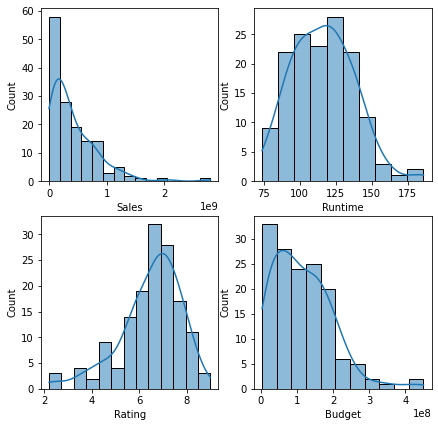

In [3]:
#Step 1 is to create a new dataframe with just the columns that we want
TestData = pd.DataFrame({'Sales':df['GrossSales'],'Rating':df['Rating'], 'Budget':df['Budget'], 'Runtime':df['Runtime']})

#Drop all rows that have a null value in one of the columns. it will still leave us with 146 valid data points
TestData.dropna(axis=0, how='any', inplace=True)

#First lets check how normal the data is using some histograms
fig, axs = plt.subplots(2, 2, figsize=(7,7))
sns.histplot(TestData, x="Sales", kde=True, ax=axs[0,0])
sns.histplot(TestData, x="Rating", kde=True, ax=axs[1,0])
sns.histplot(TestData, x="Budget", kde=True, ax=axs[1,1])
sns.histplot(TestData, x="Runtime", kde=True, ax=axs[0,1])
plt.show()


Rating is fairly normal, as is Runtime but Budget and Sales are both skewed left. Time to apply some transformations to see if we can normalize the Dependent and independent variables. For this I will apply a boxcox transformation and return the Lambda value.

Sales Lambda =  0.3101492861955896
Budget Lambda =  0.43443758883842726
Runtime Lambda =  0.20861724410626292
Rating Lambda =  2.437254200546797


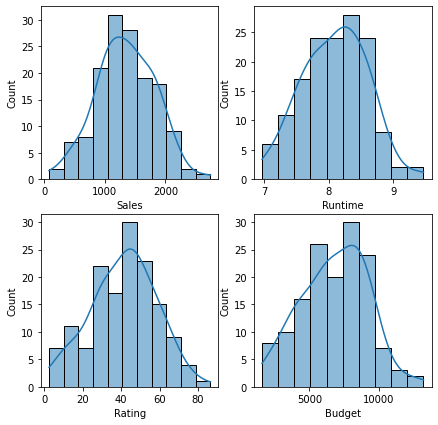

In [4]:
#Statology had a fantastic tutorial that I used for this transformation https://www.statology.org/box-cox-transformation-python/
#Transform data, and return the individual lambda value of the transformation
TestData['Sales'], salesL = stats.boxcox(TestData['Sales'])
TestData['Budget'], budgetL = stats.boxcox(TestData['Budget'])
TestData['Runtime'], runtimeL = stats.boxcox(TestData['Runtime'])
TestData['Rating'], ratingL = stats.boxcox(TestData['Rating'])

#Print out the Lambda values for use later.
print("Sales Lambda = ",salesL)
print("Budget Lambda = ",budgetL)
print("Runtime Lambda = ",runtimeL)
print("Rating Lambda = ",ratingL)

#Generate Histograms of each variable
fig, axs = plt.subplots(2, 2, figsize=(7,7))
sns.histplot(TestData, x="Sales", kde=True, ax=axs[0,0])
sns.histplot(TestData, x="Rating", kde=True, ax=axs[1,0])
sns.histplot(TestData, x="Budget", kde=True, ax=axs[1,1])
sns.histplot(TestData, x="Runtime", kde=True, ax=axs[0,1])
plt.show()

That is better for Budget, Sales is still skewed but I don't think we are able to transform that enough.

            Sales    Rating    Budget   Runtime
Sales    1.000000  0.621983  0.755800  0.583715
Rating   0.621983  1.000000  0.321776  0.507558
Budget   0.755800  0.321776  1.000000  0.644615
Runtime  0.583715  0.507558  0.644615  1.000000


<AxesSubplot:>

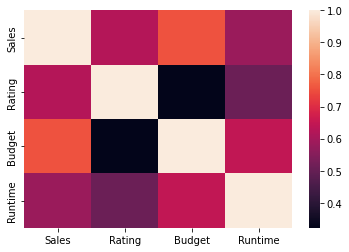

In [5]:
#Generate the Correlation values and print them so that we can see it numerically
print(TestData.corr())

#Generate a heatmap so that we can see it visually as well.
sns.heatmap(TestData.corr(), xticklabels=TestData.columns, yticklabels=TestData.columns)

There does not appear to be any issues with colinearity since none of the correlation pairs have a value over 0.9.

In [6]:
#Credit to Adi Bronshtein for the quick tutorial to get this up and running https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
#Split data into two series, one for the Dependent (Target) and one for the Independent Variables (predictors)
target = TestData['Sales']
predictors = TestData[['Rating', 'Runtime', 'Budget']]

#Add constant and generate a linear fit model
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()

#Output a summary of the model so that we can evaluate it.
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     130.1
Date:                Sun, 22 May 2022   Prob (F-statistic):           1.50e-40
Time:                        16:10:34   Log-Likelihood:                -1012.5
No. Observations:                 146   AIC:                             2033.
Df Residuals:                     142   BIC:                             2045.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        417.2370    422.408      0.988      0.325    -417.784    1252.258
Rating        12.5835      1.427      8.815      0.000       9.762      15.405
Runtime      -60.3853     60.092     -1.005      0.317    -179.175      58.405
Budget         0.1316      0.011     11.524      0.000       0.109       0.154
==============================================================================
Omnibus:                       39.221   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.828
Skew:                          -0.946   Prob(JB):                     3.20e-30
Kurtosis:                       7.330   Cond. No.                     1.48e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Well the P-Value for runtime is high, so that is a variable that I can eliminate. I want it to be below 0.05, but it is 0.317.

In [7]:
#Set our target and predictors again, excluding Runtime as it is not Significant
target = TestData['Sales']
predictors = TestData[['Rating', 'Budget']]

#Refit the model now that Runtime is gone.
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
predictions = model.predict(predictors)

#Output model summary again so that we can evaluate it.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     194.6
Date:                Sun, 22 May 2022   Prob (F-statistic):           1.57e-41
Time:                        16:10:35   Log-Likelihood:                -1013.0
No. Observations:                 146   AIC:                             2032.
Df Residuals:                     143   BIC:                             2041.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1440     71.298     -0.016      0.987    -142.079     139.791
Rating        11.9887      1.299      9.229      0.000       9.421      14.557
Budget         0.1248      0.009     13.538      0.000       0.107       0.143
==============================================================================
Omnibus:                       40.375   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.963
Skew:                          -0.978   Prob(JB):                     4.05e-31
Kurtosis:                       7.380   Cond. No.                     2.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing Runtime did not lower the R-Squared, which is good! Our model still covers 72.8% of the variability in the data. Time to see how the predicted values compare to the raw Sales data!

[Text(0, 0.5, 'Predicted Values'), Text(0.5, 0, 'Actual Values')]

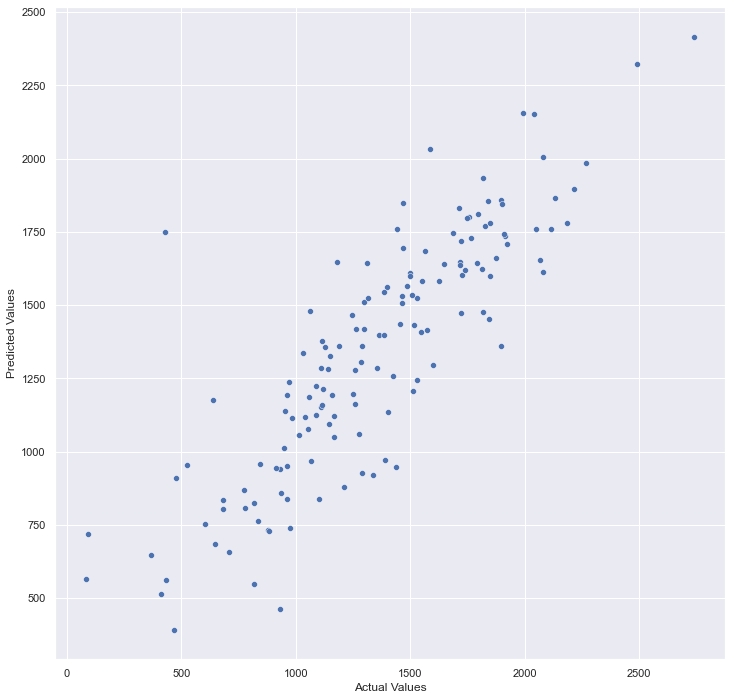

In [8]:
#Generate scatter plot comparing our predicted values to the sales data
sns.set(rc = {'figure.figsize': (12,12)}) #Make the scatter plot bigger
plot = sns.scatterplot(x=target, y=predictions)
plot.set(ylabel="Predicted Values", xlabel="Actual Values")

Good, while there is a fair amount of variation it is still a linear relationship that appears to have a 45 degree angle. This model is a good start, but it can definitely be improved upon in the future.

So what conclusions can I gather from my investigation?

First, runtime does not appear to have a significant impact on the Revenue (Sales) generated by a movie.

Second, Budget has a significant impact on the Revenue (Sales) of a super hero movie. This makes sense since many viewers go to see Super hero movies for the combat scenes and the grand spectacles, so a low budget would hinder that experience. Word of mouth would then cause many prospective buyers to view another movie. 

Third, Ratings also have an effect on the Revenue of a Super Hero film. Early ratings would allow many of the viewers to guage whether they should view the movie or not. Lower ratings would lead many to ignore it in order to pursue entertainment they view as more worth their time.

This model may not be the best possible one for the subject, there are several other variables I would like to explore the in the future. For example, how does the release month impact the sales? I could accomplish this by making each month its own variable (X12 = 1 if month is December, etc). 

An important note is that the data was transformed, meaning that the equation is not as simple as y= mx + b.

Regression Equation:

Sales^(0.31) = -1.1440 + 0.1248xBudget^(0.434) + 11.9887xRating^(2.437)